In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import re
from spellchecker import SpellChecker
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity

path = os.path.dirname(os.path.abspath("__file__"))
ppath = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(ppath)

from summary_eval.data import summary_df, prompts_df
from summary_eval.settings import TRAIN_SIZE

ModuleNotFoundError: No module named 'spellchecker'

In [122]:
train_df, test_df = train_test_split(summary_df, train_size=TRAIN_SIZE, random_state=42)

In the prompts, they ask for specific things to be in the summary. Maybe we can use the question as well as the prompt text to determine score

In [123]:
print(prompts_df['prompt_question'].iloc[0])

Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.


In [124]:
print(prompts_df['prompt_question'].iloc[1])

In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.


Correlation coefficient between wording and content: 0.7572798084813561


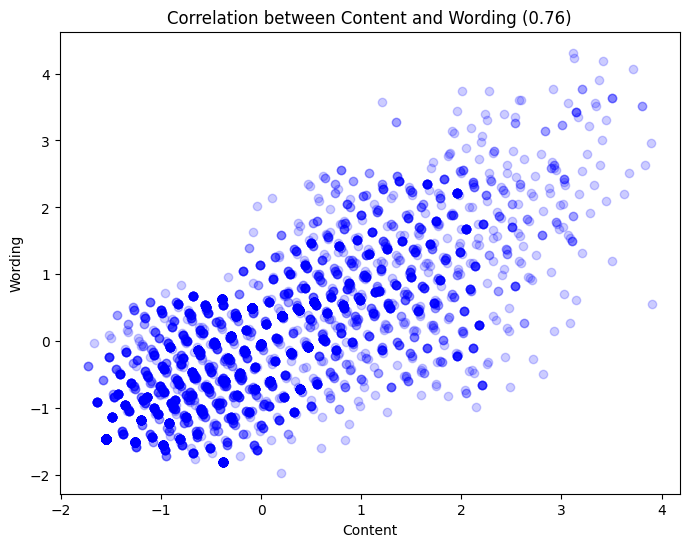

In [125]:
correlation = train_df['content'].corr(train_df['wording'])
print(f"Correlation coefficient between wording and content: {correlation}")

plt.figure(figsize=(8, 6))
plt.scatter(train_df['content'], train_df['wording'], c='b', label='Wording', alpha=0.2)
plt.xlabel('Content')
plt.ylabel('Wording')
plt.title(f'Correlation between Content and Wording ({correlation:.2f})')

plt.show()

Correlation Matrix:
          content  wording        qp
content  1.000000  0.75728  0.160687
wording  0.757280  1.00000  0.031650
qp       0.160687  0.03165  1.000000


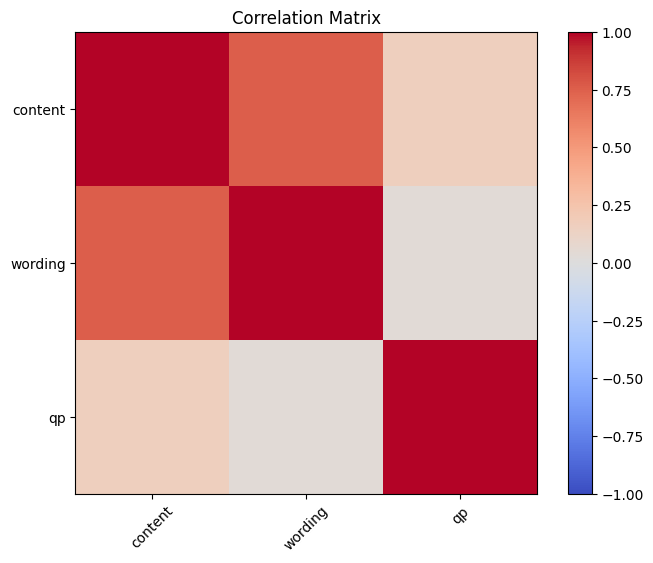

In [126]:
def count_quoted_chars(text):
    quoted_substrings = re.findall(r'"([^"]*)"|\'([^\']*)\'', text)
    total_quoted_chars = sum(len(s) for s in quoted_substrings)

    return total_quoted_chars

quote_perc = []
for _, row in train_df.iterrows():
    quote_perc.append(count_quoted_chars(row['text']) / len(row['text']))

train_df['qp'] = quote_perc

corr_matrix = train_df[['content', 'wording', 'qp']].corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

In progress: spellcheck comparison

In [127]:
# spell = SpellChecker()

# def calculate_spell_check_difference(text):
#     # corrected_text = spell.correction(text)
    
#     # new_text = len(corrected_text)
#     # org_text = len(text)
#     # diff = abs(org_text - new_text)

#     # ans = 1-diff/org_text
#     # print(ans)
#     # return ans

# spellcheck = []
# for _, row in train_df.iterrows():
#     spellcheck.append(calculate_spell_check_difference(row['text']))

# train_df['spellcheck'] = spellcheck

# corr_matrix = train_df[['content', 'wording', 'spellcheck']].corr()

# print("Correlation Matrix:")
# print(corr_matrix)

# plt.figure(figsize=(8, 6))
# plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
# plt.colorbar()
# plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
# plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
# plt.title('Correlation Matrix')
# plt.show()

In [128]:
prompts = {}

for _, row in prompts_df.iterrows():
    prompts[row['prompt_id']] = row['prompt_text']

In [129]:
data = []
for _, row in train_df.iterrows():
    data.append({
        'text': prompts[row['prompt_id']] + ' ' + row['text'],
        'content_score': row['content'],
        'wording_score': row['wording']
    })

df = pd.DataFrame(data)

In [130]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

nmf = NMF(n_components=10, random_state=42)
nmf_topics = nmf.fit_transform(tfidf_matrix)

df['lda_topics'] = list(lda_topics)
df['nmf_topics'] = list(nmf_topics)

In [131]:
df['topic_similarity'] = df.apply(lambda row: cosine_similarity([row['lda_topics']], [row['nmf_topics']])[0][0], axis=1)

Correlation Matrix:
                  topic_similarity  wording_score  content_score
topic_similarity          1.000000       0.139326       0.232195
wording_score             0.139326       1.000000       0.757280
content_score             0.232195       0.757280       1.000000


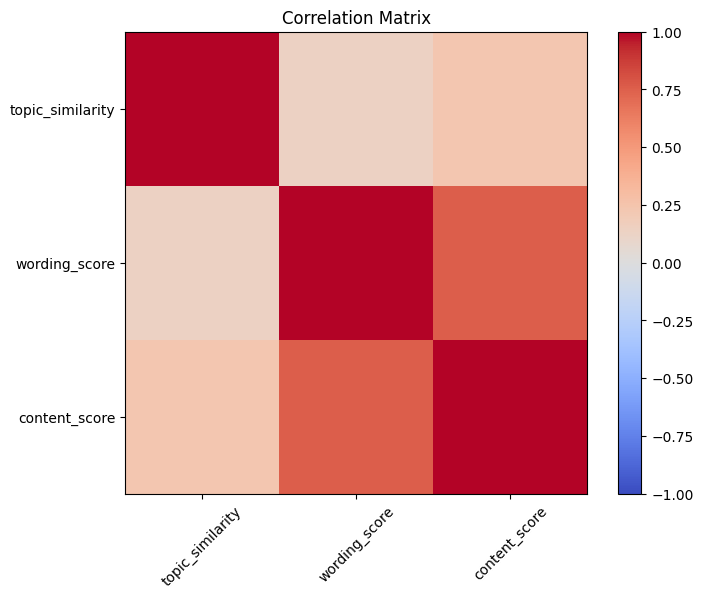

In [132]:
corr_matrix = df[['topic_similarity', 'wording_score', 'content_score']].corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

Idea: check similarity between prompt text and summary text